# Imports

#### PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [2]:
print('PyTorch version', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

PyTorch version 2.5.1
Device: cuda


#### General

In [3]:
import os
import json
import math
import time
import random
from pathlib import Path
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

from sklearn.metrics import roc_auc_score

#### Monai

In [4]:
from monai.losses import DiceLoss, FocalLoss

# Parameters

#### Directories for the images

In [5]:
parent = Path().cwd().parent
data_root = parent / 'try_1'

train_images_dir = data_root / 'train' / 'images'
train_masks_dir = data_root / 'train' / 'masks'

val_images_dir = data_root / 'val' / 'images'
val_masks_dir = data_root / 'val' / 'masks'

#### General parameters

In [6]:
IMG_HEIGHT = 768
IMG_WIDTH = 768

BATCH_SIZE = 4

EPOCHS = 100
print('Number of epochs:', EPOCHS)

LR = 0.0005
print('Learning rate:', LR)

"""
0 : background (black)
1 : arteries (white)
2 : veins (gray)
"""
NUM_CLASSES = 3

COLOR_TO_LABEL = {
    (0,0,0): 0,
    (255,255,255): 1,
    (128,128,128): 2
}

Number of epochs: 100
Learning rate: 0.0005


# DataLoaders

#### Create the class for the dataset images

In [7]:
class RAVIRDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH), transforms=None):
        self.img_paths = sorted(list(Path(img_dir).glob('*.png')))
        self.mask_dir = Path(mask_dir)
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_p = self.img_paths[idx]
        mask_p = self.mask_dir / img_p.name
        img = Image.open(img_p).convert('RGB').resize(self.img_size, Image.BILINEAR)
        img = np.array(img, dtype=np.float32) / 255.0
        img = np.transpose(img, (2,0,1))  # C,H,W
        img_t = torch.from_numpy(img).float()
        # load mask and map colors to labels
        m = Image.open(mask_p).convert('RGB').resize(self.img_size, Image.NEAREST)
        m_arr = np.array(m, dtype=np.uint8)
        label = np.zeros((self.img_size[1], self.img_size[0]), dtype=np.uint8)
        for color, lab in COLOR_TO_LABEL.items():
            mask = np.all(m_arr == np.array(color, dtype=np.uint8), axis=-1)
            label[mask] = lab
        label_t = torch.from_numpy(label).long()  # H,W
        return img_t, label_t

In [8]:
train_ds = RAVIRDataset(train_images_dir, train_masks_dir, (IMG_WIDTH, IMG_HEIGHT))
val_ds = RAVIRDataset(val_images_dir, val_masks_dir, (IMG_WIDTH, IMG_HEIGHT))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# U-Net model

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, n_classes=NUM_CLASSES, in_channels=3, features=[32,64,128,256]):
        super().__init__()
        self.encs = nn.ModuleList()
        self.pools = nn.ModuleList()
        for f in features:
            self.encs.append(DoubleConv(in_channels, f))
            self.pools.append(nn.MaxPool2d(2))
            in_channels = f
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        # decoder
        self.upconvs = nn.ModuleList()
        self.decs = nn.ModuleList()
        for f in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(f*2, f, kernel_size=2, stride=2))
            self.decs.append(DoubleConv(f*2, f))
        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skips = []
        for enc, pool in zip(self.encs, self.pools):
            x = enc(x)
            skips.append(x)
            x = pool(x)
        x = self.bottleneck(x)
        for up, dec, skip in zip(self.upconvs, self.decs, reversed(skips)):
            x = up(x)
            # pad if needed
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:])
            x = torch.cat([skip, x], dim=1)
            x = dec(x)
        x = self.final_conv(x)
        return x

model = UNet().to(device)
# print(model)

# Optimizer

In [10]:
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Loss function

In [14]:
percentage = [0.872, 0.054, 0.073]
inverse_percentage = [(1/p)/5.5 for p in percentage]
print(inverse_percentage)

weights = torch.tensor(inverse_percentage).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

[0.2085070892410342, 3.367003367003367, 2.4906600249066004]


# Model train

In [15]:
best_val_loss = float("inf")
model_name = "My_UNet_v2_3"
save_dir = Path("Models") / model_name
save_dir.mkdir(parents=True, exist_ok=True)
last_epoch_save = 0

In [16]:
NUM_CLASSES = 3
BACKGROUND_IDX = 0
VESSEL_CLASSES = [1, 2]

In [17]:
# ===========================================
#   DICTIONNAIRES STOCRAGE (MEAN ONLY)
# ===========================================

train_history = {
    "loss": [],
    "accuracy":   [],
    "dice":       [],
    "iou":        [],
    "precision":  [],
    "recall":     [],
    "sensitivity":[],
    "specificity":[],
    "auc":        []
}

val_history = {
    "loss": [],
    "accuracy":   [],
    "dice":       [],
    "iou":        [],
    "precision":  [],
    "recall":     [],
    "sensitivity":[],
    "specificity":[],
    "auc":        []
}

In [18]:
# =========================
#          INIT
# =========================

def init_confmat_sums(num_classes=NUM_CLASSES) :
    sums = {
        "TP" : np.zeros(num_classes, dtype=np.int64),
        "FP" : np.zeros(num_classes, dtype=np.int64),
        "FN" : np.zeros(num_classes, dtype=np.int64),
        "TN" : np.zeros(num_classes, dtype=np.int64),
        "N"  : 0
    }
    return sums

def init_auc_buffers(include_classes=VESSEL_CLASSES) :
    return {c : {"y_true" : [], "y_score" : []} for c in include_classes}

In [19]:
# =========================
#         UPDATE
# =========================

def update_confmat_sums(sums, preds, targets, num_classes=NUM_CLASSES) :
    with torch.no_grad() :
        for c in range(num_classes) :
            p = (preds == c)
            t = (targets == c)
            tp = (p & t).sum().item()
            fp = (p & ~t).sum().item()
            fn = (~p & t).sum().item()
            tn = (~p & ~t).sum().item()
            sums["TP"][c] += tp
            sums["FP"][c] += fp
            sums["FN"][c] += fn
            sums["TN"][c] += tn
        sums["N"] += targets.numel()



def update_auc_buffers(buffers, logits, targets):
    with torch.no_grad():
        probs = F.softmax(logits, dim=1)
        flat_probs = probs.permute(0,2,3,1).reshape(-1, probs.shape[1])
        flat_t     = targets.reshape(-1)

        for c in buffers.keys():
            y_true = (flat_t == c).cpu().numpy().astype(np.uint8)
            y_score = flat_probs[:, c].cpu().numpy()
            buffers[c]["y_true"].append(y_true)
            buffers[c]["y_score"].append(y_score)

In [20]:
def compute_scalar_metrics_from_confmat(sums, include_classes):
    TP, FP, FN, TN = sums["TP"], sums["FP"], sums["FN"], sums["TN"]
    eps = 1e-7

    acc_c  = (TP + TN) / np.maximum(TP + TN + FP + FN, eps)
    prec_c = TP / np.maximum(TP + FP, eps)
    rec_c  = TP / np.maximum(TP + FN, eps)
    spec_c = TN / np.maximum(TN + FP, eps)
    dice_c = (2 * TP) / np.maximum(2 * TP + FP + FN, eps)
    iou_c  = TP / np.maximum(TP + FP + FN, eps)

    idx = np.array(include_classes, dtype=int)
    return {
        "accuracy":   float(np.mean(acc_c[idx])),
        "precision":  float(np.mean(prec_c[idx])),
        "recall":     float(np.mean(rec_c[idx])),
        "specificity":float(np.mean(spec_c[idx])),
        "dice":       float(np.mean(dice_c[idx])),
        "iou":        float(np.mean(iou_c[idx])),
    }

In [21]:
def compute_mean_auc(buffers):
    aucs = []
    for c, pack in buffers.items():
        if len(pack["y_true"]) == 0: 
            continue
        y_true = np.concatenate(pack["y_true"])
        y_score = np.concatenate(pack["y_score"])
        pos = (y_true == 1).sum()
        neg = (y_true == 0).sum()
        if pos == 0 or neg == 0:
            continue
        try:
            aucs.append(roc_auc_score(y_true, y_score))
        except:
            pass
    if len(aucs) == 0:
        return float("nan")
    return float(np.mean(aucs))

In [22]:
# =========================
#        LEARNING
# =========================

for epoch in range(EPOCHS) :

    # =========================
    #        TRAIN
    # =========================

    model.train()

    runing_loss = 0.0
    conf_sums = init_confmat_sums()
    auc_buf = init_auc_buffers()

    for imgs, masks in train_loader :

        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        runing_loss += loss.item() * imgs.size(0)

        preds = outputs.argmax(dim=1)
        update_confmat_sums(conf_sums, preds, masks, NUM_CLASSES)
        update_auc_buffers(auc_buf, outputs, masks)
    
    train_loss = runing_loss / len(train_ds)
    train_metrics = compute_scalar_metrics_from_confmat(conf_sums, VESSEL_CLASSES)
    train_auc = compute_mean_auc(auc_buf)

    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_metrics["accuracy"])
    train_history["dice"].append(train_metrics["dice"])
    train_history["iou"].append(train_metrics["iou"])
    train_history["precision"].append(train_metrics["precision"])
    train_history["recall"].append(train_metrics["recall"])
    train_history["specificity"].append(train_metrics["specificity"])
    train_history["auc"].append(train_auc)




    # =========================
    #       VALIDATION
    # =========================
    model.eval()

    val_runing_loss = 0.0
    conf_sums_val = init_confmat_sums()
    auc_buf_val   = init_auc_buffers()

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs  = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            outputs = model(imgs)
            loss = criterion(outputs, masks)
            val_runing_loss += loss.item() * imgs.size(0)

            preds = outputs.argmax(dim=1)
            update_confmat_sums(conf_sums_val, preds, masks, NUM_CLASSES)
            update_auc_buffers(auc_buf_val, outputs, masks)

    val_loss = val_runing_loss / len(val_ds)
    val_metrics = compute_scalar_metrics_from_confmat(conf_sums_val, VESSEL_CLASSES)
    val_auc = compute_mean_auc(auc_buf_val)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_metrics["accuracy"])
    val_history["dice"].append(val_metrics["dice"])
    val_history["iou"].append(val_metrics["iou"])
    val_history["precision"].append(val_metrics["precision"])
    val_history["recall"].append(val_metrics["recall"])
    val_history["specificity"].append(val_metrics["specificity"])
    val_history["auc"].append(val_auc)

    scheduler.step()


    # =========================
    #           LOGS
    # =========================
    print('-'*30)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Dice: {train_metrics['dice']:.4f} | IoU: {train_metrics['iou']:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Dice: {val_metrics['dice']:.4f} | IoU: {val_metrics['iou']:.4f}")

    # =========================
    #     SAVE BEST MODEL
    # =========================
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), str(save_dir / "best_model_state_dict.pth"))
        torch.save(model, str(save_dir / "best_model_full.pth"))
        print(f"✅ Nouveau meilleur modèle sauvegardé")


------------------------------
Epoch 1/100
  Train Loss: 1.0786 | Dice: 0.0695 | IoU: 0.0373
  Val   Loss: 1.0854 | Dice: 0.0640 | IoU: 0.0342
✅ Nouveau meilleur modèle sauvegardé
------------------------------
Epoch 2/100
  Train Loss: 1.0738 | Dice: 0.0695 | IoU: 0.0373
  Val   Loss: 1.0833 | Dice: 0.0640 | IoU: 0.0342
✅ Nouveau meilleur modèle sauvegardé
------------------------------
Epoch 3/100
  Train Loss: 1.0671 | Dice: 0.0695 | IoU: 0.0373
  Val   Loss: 1.0888 | Dice: 0.0640 | IoU: 0.0342
------------------------------
Epoch 4/100
  Train Loss: 1.0641 | Dice: 0.0695 | IoU: 0.0373
  Val   Loss: 1.0790 | Dice: 0.0640 | IoU: 0.0342
✅ Nouveau meilleur modèle sauvegardé
------------------------------
Epoch 5/100
  Train Loss: 1.0583 | Dice: 0.0695 | IoU: 0.0373
  Val   Loss: 1.0752 | Dice: 0.0640 | IoU: 0.0342
✅ Nouveau meilleur modèle sauvegardé
------------------------------
Epoch 6/100
  Train Loss: 1.0472 | Dice: 0.0695 | IoU: 0.0374
  Val   Loss: 1.0619 | Dice: 0.0649 | IoU: 0

In [23]:
with open(save_dir / "UNet_v2_3_train_history.json", "w") as f:
    json.dump(train_history, f, indent=4)

with open(save_dir / "UNet_v2_3_val_history.json", "w") as f:
    json.dump(val_history, f, indent=4)

print("Historiques sauvegardés en JSON")

Historiques sauvegardés en JSON


# Validation tests

#### Load the best model

In [24]:
model = torch.load(save_dir / "best_model_full.pth")

/tmp/ipykernel_1180969/1138156330.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(save_dir / "best_model_full.pth")


#### Images

In [22]:
model.eval()
total_correct = 0
total_pixels = 0

# 📁 Dossier pour sauvegarder les prédictions
pred_dir = save_dir / "predictions"
pred_dir.mkdir(parents=True, exist_ok=True)

with torch.no_grad():
    img_index = 0  # compteur global des images

    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        # Boucle sur chaque image du batch
        for i in range(len(imgs)):
            pred = preds[i]
            mask = masks[i]

            # ===== Calcul de l’accuracy de cette image =====
            correct_pixels = (pred == mask).sum().item()
            total_pixels_img = mask.numel()
            acc_img = correct_pixels / total_pixels_img

            print(f"🖼️ Image {img_index+1} — Accuracy : {acc_img:.4f}")

            # ===== Affichage + Sauvegarde =====
            fig, ax = plt.subplots(1, 3, figsize=(10, 4))
            ax[0].imshow(imgs[i].cpu().permute(1, 2, 0))
            ax[0].set_title("Original picture")
            ax[1].imshow(mask.cpu(), cmap="gray")
            ax[1].set_title("Real mask")
            ax[2].imshow(pred.cpu(), cmap="gray")
            ax[2].set_title("Predicted mask")
            for a in ax:
                a.axis("off")
            plt.tight_layout()

            # 📌 Sauvegarde dans Models/<model_name>/predictions/
            save_path = pred_dir / f"val_img_{img_index:03d}.png"
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.close(fig)  # important pour ne pas consommer de mémoire

            # ===== Accumulateur global =====
            total_correct += correct_pixels
            total_pixels += total_pixels_img
            img_index += 1

# ===== Accuracy globale =====
val_acc = total_correct / total_pixels
print(f"\n✅ Accuracy moyenne sur le jeu de validation : {val_acc:.4f}")


🖼️ Image 1 — Accuracy : 0.9127
🖼️ Image 2 — Accuracy : 0.9057
🖼️ Image 3 — Accuracy : 0.8992
🖼️ Image 4 — Accuracy : 0.9006
🖼️ Image 5 — Accuracy : 0.8431

✅ Accuracy moyenne sur le jeu de validation : 0.8923


🖼️ Image 1 — Accuracy : 0.8167


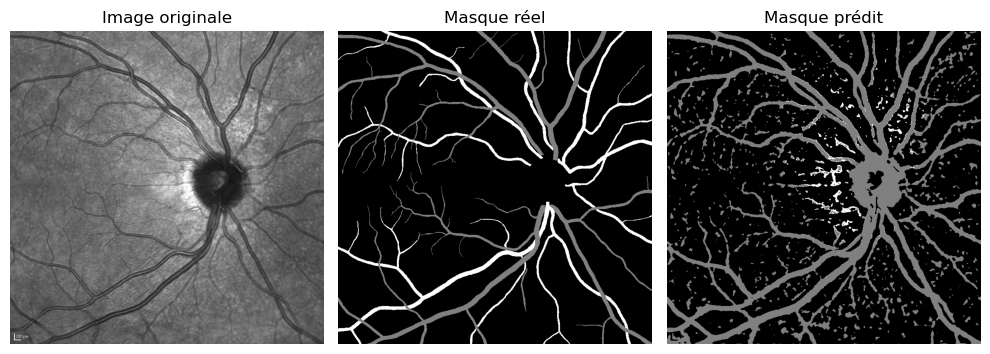

🖼️ Image 2 — Accuracy : 0.7811


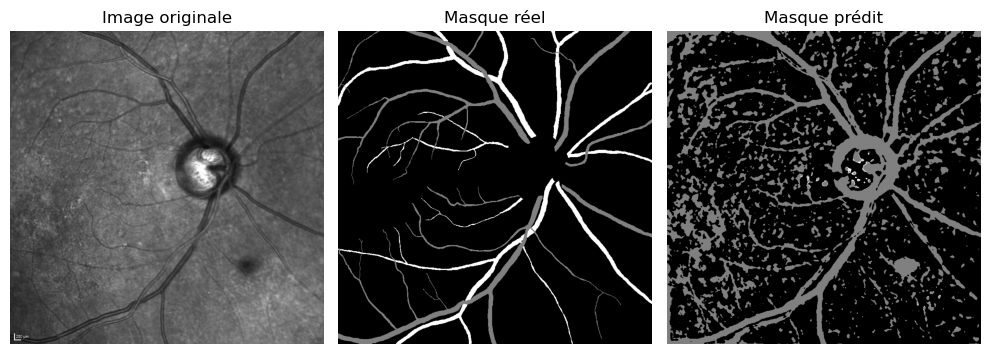

🖼️ Image 3 — Accuracy : 0.7477


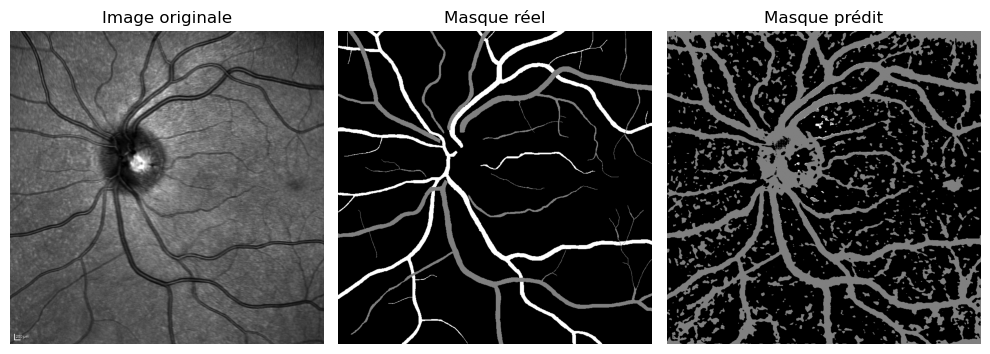

🖼️ Image 4 — Accuracy : 0.8950


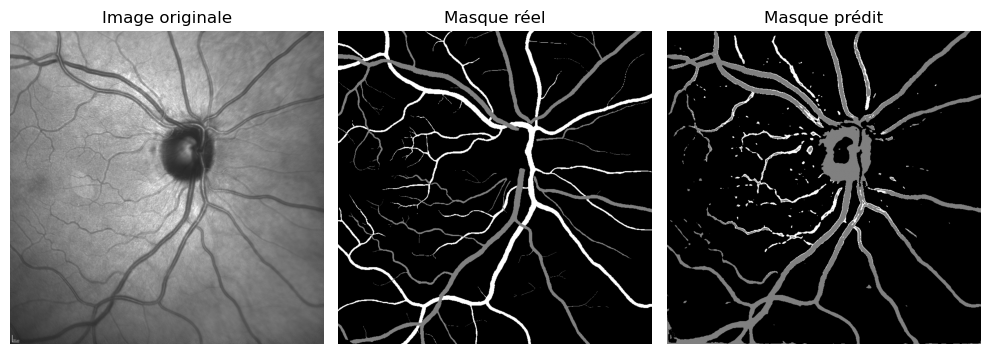

🖼️ Image 5 — Accuracy : 0.8129


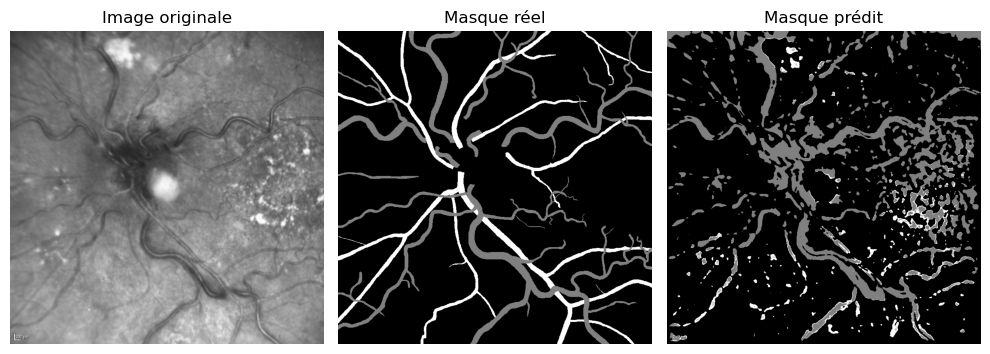


✅ Accuracy moyenne sur le jeu de validation : 0.8107


In [25]:
model.eval()
total_correct = 0
total_pixels = 0

with torch.no_grad():
    img_index = 0  # compteur global des images

    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        # Boucle sur chaque image du batch
        for i in range(len(imgs)):
            pred = preds[i]
            mask = masks[i]

            # ===== Calcul de l’accuracy de cette image =====
            correct_pixels = (pred == mask).sum().item()
            total_pixels_img = mask.numel()
            acc_img = correct_pixels / total_pixels_img

            print(f"🖼️ Image {img_index+1} — Accuracy : {acc_img:.4f}")

            # ===== Affichage visuel =====
            fig, ax = plt.subplots(1, 3, figsize=(10, 4))
            ax[0].imshow(imgs[i].cpu().permute(1, 2, 0))
            ax[0].set_title("Image originale")
            ax[1].imshow(mask.cpu(), cmap="gray")
            ax[1].set_title("Masque réel")
            ax[2].imshow(pred.cpu(), cmap="gray")
            ax[2].set_title("Masque prédit")
            for a in ax:
                a.axis("off")
            plt.tight_layout()
            plt.show()

            # ===== Accumulateur global =====
            total_correct += correct_pixels
            total_pixels += total_pixels_img
            img_index += 1

# ===== Accuracy globale =====
val_acc = total_correct / total_pixels
print(f"\n✅ Accuracy moyenne sur le jeu de validation : {val_acc:.4f}")


🖼️ Image 1 — Accuracy : 0.9127


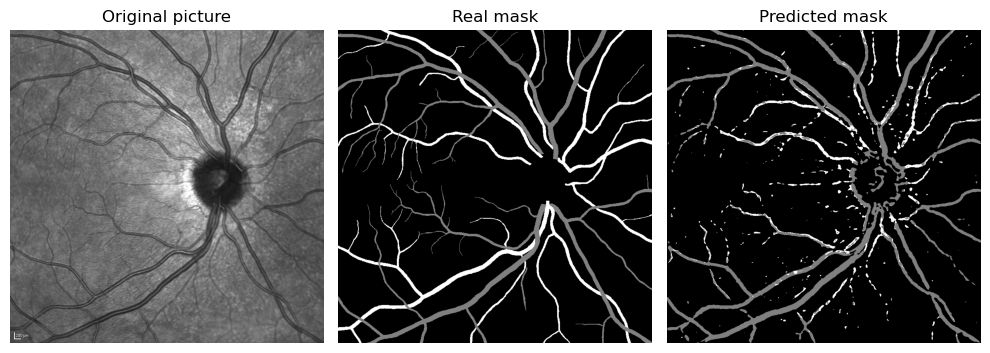

🖼️ Image 2 — Accuracy : 0.9057


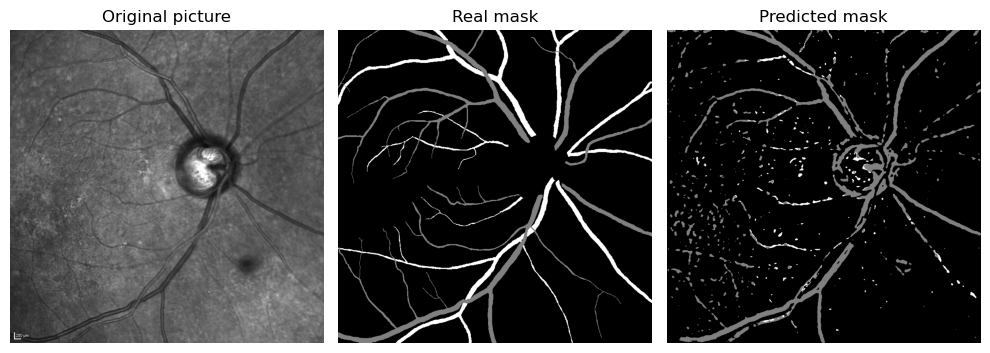

🖼️ Image 3 — Accuracy : 0.8992


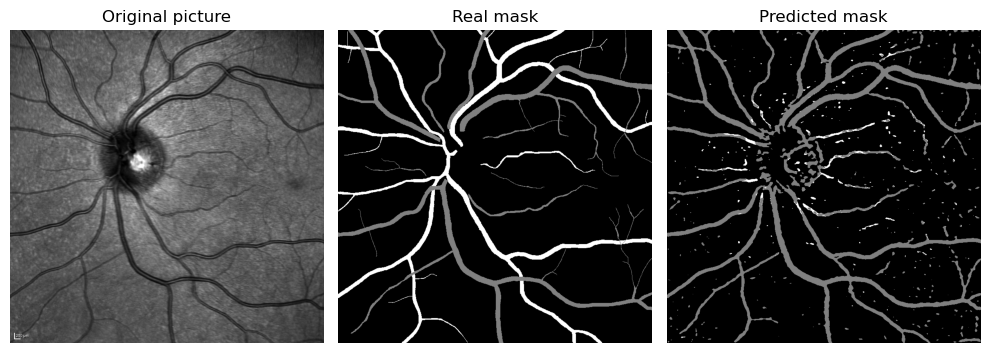

🖼️ Image 4 — Accuracy : 0.9006


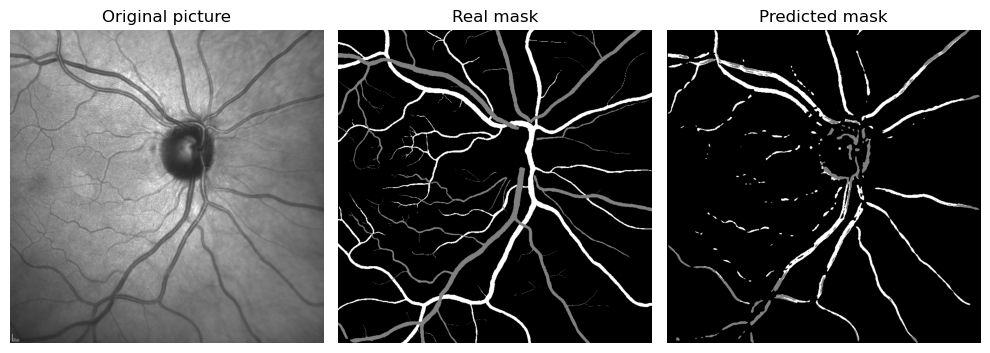

🖼️ Image 5 — Accuracy : 0.8431


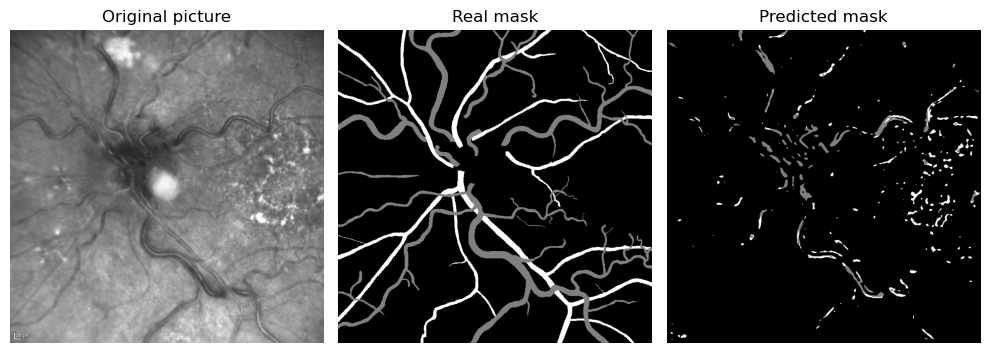


✅ Accuracy moyenne sur le jeu de validation : 0.8923


In [24]:
model.eval()
total_correct = 0
total_pixels = 0

# 📁 Dossier pour sauvegarder les prédictions
pred_dir = save_dir / "predictions"
pred_dir.mkdir(parents=True, exist_ok=True)

with torch.no_grad():
    img_index = 0  # compteur global des images

    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)

        # Boucle sur chaque image du batch
        for i in range(len(imgs)):
            pred = preds[i]
            mask = masks[i]

            # ===== Calcul de l’accuracy de cette image =====
            correct_pixels = (pred == mask).sum().item()
            total_pixels_img = mask.numel()
            acc_img = correct_pixels / total_pixels_img

            print(f"🖼️ Image {img_index+1} — Accuracy : {acc_img:.4f}")

            # ===== Création de la figure =====
            fig, ax = plt.subplots(1, 3, figsize=(10, 4))
            ax[0].imshow(imgs[i].cpu().permute(1, 2, 0))
            ax[0].set_title("Original picture")
            ax[1].imshow(mask.cpu(), cmap="gray")
            ax[1].set_title("Real mask")
            ax[2].imshow(pred.cpu(), cmap="gray")
            ax[2].set_title("Predicted mask")
            for a in ax:
                a.axis("off")
            plt.tight_layout()

            # 📌 Sauvegarde dans Models/<model_name>/predictions/
            save_path = pred_dir / f"val_img_{img_index:03d}.png"
            plt.savefig(save_path, dpi=150, bbox_inches='tight')

            # ✅ Affichage immédiat dans notebook
            plt.show()

            # ===== Accumulateur global =====
            total_correct += correct_pixels
            total_pixels += total_pixels_img
            img_index += 1

# ===== Accuracy globale =====
val_acc = total_correct / total_pixels
print(f"\n✅ Accuracy moyenne sur le jeu de validation : {val_acc:.4f}")


#### Curves

💾 Courbe sauvegardée : Models/My_UNet_v2/curves/loss.png


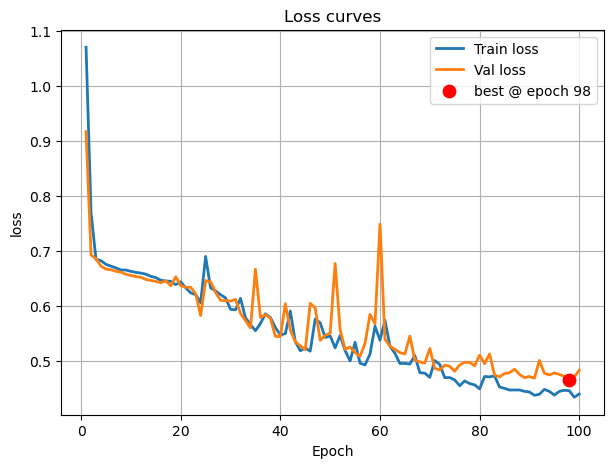

💾 Courbe sauvegardée : Models/My_UNet_v2/curves/dice.png


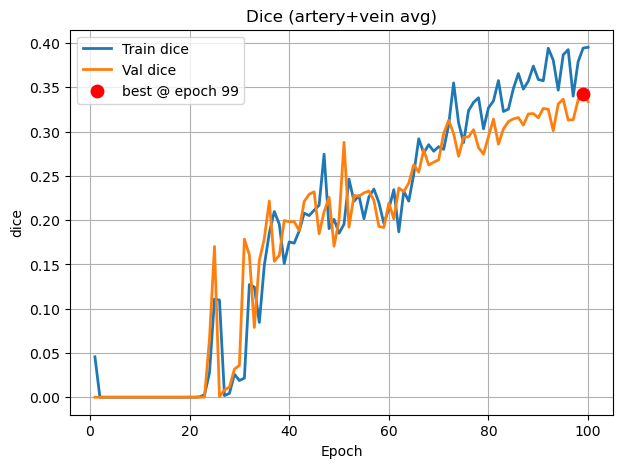

💾 Courbe sauvegardée : Models/My_UNet_v2/curves/auc.png


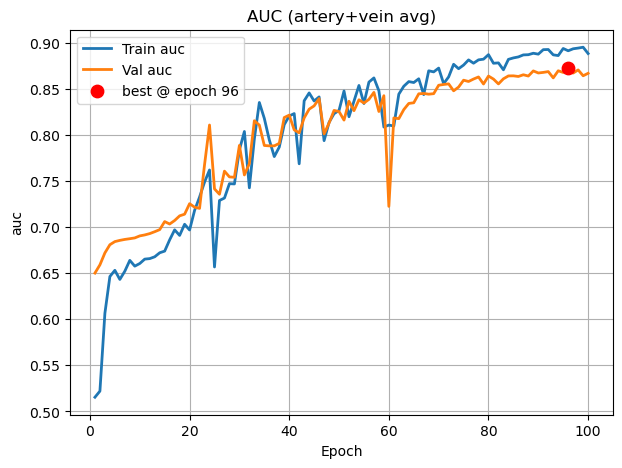

In [25]:
# --- Création du dossier d'enregistrement ---
curves_dir = save_dir / "curves"
curves_dir.mkdir(parents=True, exist_ok=True)

def plot_metric(train_history, val_history, key, title=None, mark_best_on="val_loss", save_folder=curves_dir):
    """
    key:        nom de la métrique dans les dicts (ex: "loss", "dice", "auc")
    mark_best_on:
        - "val_loss" → marquer l'epoch où val_loss est minimal
        - "val_<key>" → marquer la meilleure valeur de cette métrique (max)
    """

    train = train_history.get(key, [])
    val   = val_history.get(key, [])

    if len(val) == 0:
        print(f"⚠️ Impossible de tracer '{key}' (pas de valeurs validation trouvées)")
        return

    epochs = range(1, len(val)+1)

    plt.figure(figsize=(7,5))
    plt.plot(epochs, train, label=f"Train {key}", linewidth=2)
    plt.plot(epochs, val,   label=f"Val {key}", linewidth=2)

    # ========= Marqueur du "best" =========
    if mark_best_on == "val_loss" and "loss" in val_history:
        best_e = int(np.argmin(val_history["loss"])) + 1
        best_v = val[best_e-1]
        plt.scatter([best_e], [best_v], s=80, marker="o", color="red", zorder=3,
                    label=f"best @ epoch {best_e}")
    elif mark_best_on == f"val_{key}" and len(val) > 0:
        best_e = int(np.nanargmax(val)) + 1
        best_v = val[best_e-1]
        plt.scatter([best_e], [best_v], s=80, marker="o", color="red", zorder=3,
                    label=f"best @ epoch {best_e}")

    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title or f"{key} (train vs val)")
    plt.grid(True)
    plt.legend()

    # ========= SAVE =========
    save_path = save_folder / f"{key}.png"
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    print(f"💾 Courbe sauvegardée : {save_path}")

    plt.show()   # continue à afficher


# ======== TRAÇAGE ========

plot_metric(train_history, val_history, "loss", title="Loss curves", mark_best_on="val_loss")
plot_metric(train_history, val_history, "dice", title="Dice (artery+vein avg)", mark_best_on="val_dice")
plot_metric(train_history, val_history, "auc",  title="AUC (artery+vein avg)",  mark_best_on="val_auc")


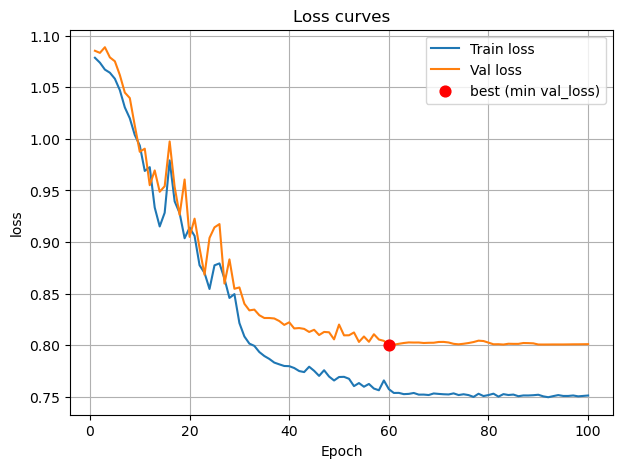

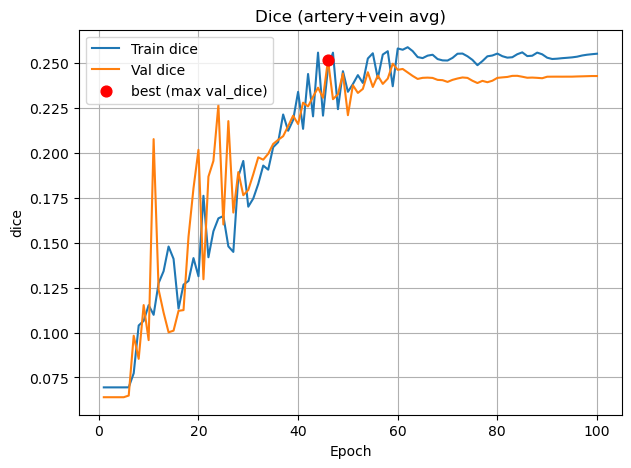

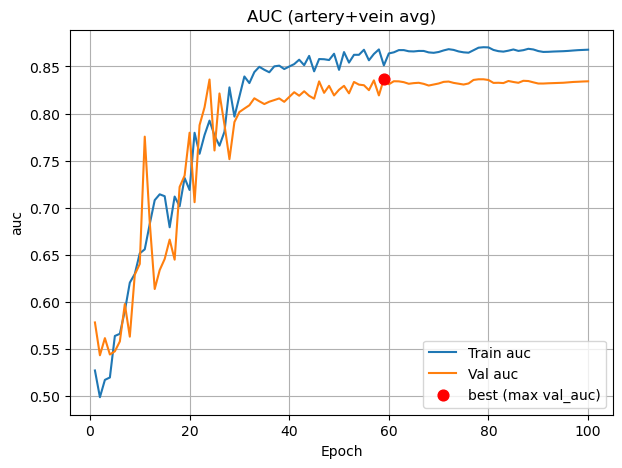

In [26]:
def plot_metric(train_history, val_history, key, title=None, mark_best_on="val_loss"):
    """
    key: la métrique à tracer (e.g. "loss", "dice", "auc")
    mark_best_on: "val_loss" (min) ou "val_<key>" si tu veux marquer le meilleur de la métrique elle-même (max)
    """
    train = train_history.get(key, [])
    val   = val_history.get(key, [])
    epochs = range(1, len(val)+1)

    plt.figure(figsize=(7,5))
    plt.plot(epochs, train, label=f"Train {key}")
    plt.plot(epochs, val,   label=f"Val {key}")

    # marqueur "best"
    if mark_best_on == "val_loss" and "loss" in val_history:
        best_e = int(np.argmin(val_history["loss"])) + 1
        best_v = val[best_e-1] if len(val)>=best_e else None
        if best_v is not None:
            plt.scatter([best_e], [best_v], s=60, marker="o", color="red", zorder=3, label="best (min val_loss)")
    elif mark_best_on == f"val_{key}" and len(val)>0:
        # si on trace une métrique à maximiser (ex: dice), on marque son max val
        best_e = int(np.nanargmax(val)) + 1
        best_v = val[best_e-1]
        plt.scatter([best_e], [best_v], s=60, marker="o", color="red", zorder=3, label=f"best (max val_{key})")

    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.title(title or f"{key} (train vs val)")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_metric(train_history, val_history, "loss", title="Loss curves", mark_best_on="val_loss")
plot_metric(train_history, val_history, "dice", title="Dice (artery+vein avg)", mark_best_on="val_dice")
plot_metric(train_history, val_history, "auc",  title="AUC (artery+vein avg)", mark_best_on="val_auc")


#### Summary of the metrics

In [27]:
import pandas as pd

# =========================
#   CONFIG CLASSES (à valider)
# =========================
ARTERY_CLASS = 1
VEIN_CLASS   = 2
VESSEL_CLASSES = [ARTERY_CLASS, VEIN_CLASS]
assert NUM_CLASSES >= 3


# =========================
#   ÉVALUATION SUR val_loader
# =========================

model.eval()
conf_sums_val = init_confmat_sums(num_classes=NUM_CLASSES)
auc_buf_val   = init_auc_buffers(include_classes=VESSEL_CLASSES)

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        update_confmat_sums(conf_sums_val, preds, masks, NUM_CLASSES)
        update_auc_buffers(auc_buf_val, outputs, masks)


# =========================
#   MÉTRIQUES PAR CLASSE
# =========================

results = {}

for cls, name in zip(VESSEL_CLASSES, ["Artery", "Vein"]):
    m = compute_per_class_metrics_from_confmat(conf_sums_val, cls)
    m["auc"] = compute_auc_for_class(auc_buf_val, cls)
    results[name] = m


# =========================
#   MOYENNES (Artery & Vein)
# =========================

avg_metrics = {
    "accuracy":     np.nanmean([results["Artery"]["accuracy"],     results["Vein"]["accuracy"]]),
    "precision":    np.nanmean([results["Artery"]["precision"],    results["Vein"]["precision"]]),
    "recall(SE)":   np.nanmean([results["Artery"]["recall"],       results["Vein"]["recall"]]),
    "specificity":  np.nanmean([results["Artery"]["specificity"],  results["Vein"]["specificity"]]),
    "dice":         np.nanmean([results["Artery"]["dice"],         results["Vein"]["dice"]]),
    "iou":          np.nanmean([results["Artery"]["iou"],          results["Vein"]["iou"]]),
    "auc":          np.nanmean([results["Artery"]["auc"],          results["Vein"]["auc"]]),
}

results["Average (A+V)"] = avg_metrics


# =========================
#   AFFICHAGE EN TABLEAU
# =========================

df = pd.DataFrame(results).T  # transpose for rows = classes

# Arrondir pour lisibilité
df = df.map(lambda x: round(x, 4))

print("\n=== Résultats de validation ===\n")
print(df)


NameError: name 'compute_per_class_metrics_from_confmat' is not defined

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

# =========================
#   CONFIG CLASSES
# =========================
ARTERY_CLASS = 1
VEIN_CLASS   = 2
VESSEL_CLASSES = [ARTERY_CLASS, VEIN_CLASS]
assert NUM_CLASSES >= 3, "NUM_CLASSES doit inclure background + artery + vein"


# =========================
#  UTILS: métriques par classe
# =========================
def compute_per_class_metrics_from_confmat(sums, c):
    TP, FP, FN, TN = sums["TP"][c], sums["FP"][c], sums["FN"][c], sums["TN"][c]
    eps = 1e-7

    acc  = (TP + TN) / max(TP + TN + FP + FN, eps)
    prec = TP / max(TP + FP, eps)
    rec  = TP / max(TP + FN, eps)
    spec = TN / max(TN + FP, eps)
    dice = (2 * TP) / max(2 * TP + FP + FN, eps)
    iou  = TP / max(TP + FP + FN, eps)

    return {
        "accuracy":   float(acc),
        "precision":  float(prec),
        "recall":     float(rec),      # Sensitivity
        "specificity":float(spec),
        "dice":       float(dice),
        "iou":        float(iou),
    }

def compute_auc_for_class(buffers, c):
    pack = buffers.get(c, None)
    if pack is None or len(pack["y_true"]) == 0:
        return float("nan")

    y_true  = np.concatenate(pack["y_true"])
    y_score = np.concatenate(pack["y_score"])

    pos = (y_true == 1).sum()
    neg = (y_true == 0).sum()
    if pos == 0 or neg == 0:
        return float("nan")

    try:
        return float(roc_auc_score(y_true, y_score))
    except:
        return float("nan")


# =========================
#   ÉVALUATION
# =========================
model.eval()
conf_sums_val = init_confmat_sums(num_classes=NUM_CLASSES)
auc_buf_val   = init_auc_buffers(include_classes=VESSEL_CLASSES)

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        update_confmat_sums(conf_sums_val, preds, masks, NUM_CLASSES)
        update_auc_buffers(auc_buf_val, outputs, masks)


# =========================
#   MÉTRIQUES PAR CLASSE
# =========================
results = {}

for cls, name in zip(VESSEL_CLASSES, ["Artery", "Vein"]):
    m = compute_per_class_metrics_from_confmat(conf_sums_val, cls)
    m["auc"] = compute_auc_for_class(auc_buf_val, cls)
    results[name] = m


# =========================
#   MOYENNES ARTERY + VEIN
# =========================
avg_metrics = {metric: np.nanmean([results["Artery"][metric], results["Vein"][metric]])
               for metric in results["Artery"].keys()}

results["Average (A+V)"] = avg_metrics


# =========================
#   AFFICHAGE TABLEAU
# =========================
df = pd.DataFrame(results).T
df = df.round(4)

print("\n=== Résultats de validation ===\n")

display(df.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '13pt')]}]
))



=== Résultats de validation ===



,accuracy,precision,recall,specificity,dice,iou,auc
Artery,0.929200,0.481600,0.460100,0.963600,0.470600,0.307700,0.894100
Vein,0.935200,0.369000,0.138200,0.985200,0.201100,0.111800,0.846600
Average (A+V),0.932200,0.425300,0.299100,0.974400,0.335800,0.209700,0.870300


In [27]:
# =========================
#   CONFIG CLASSES
# =========================
ARTERY_CLASS = 1
VEIN_CLASS   = 2
VESSEL_CLASSES = [ARTERY_CLASS, VEIN_CLASS]
assert NUM_CLASSES >= 3, "NUM_CLASSES doit inclure background + artery + vein"


# =========================
#  UTILS: métriques par classe
# =========================
def compute_per_class_metrics_from_confmat(sums, c):
    TP, FP, FN, TN = sums["TP"][c], sums["FP"][c], sums["FN"][c], sums["TN"][c]
    eps = 1e-7

    acc  = (TP + TN) / max(TP + TN + FP + FN, eps)
    prec = TP / max(TP + FP, eps)
    rec  = TP / max(TP + FN, eps)
    spec = TN / max(TN + FP, eps)
    dice = (2 * TP) / max(2 * TP + FP + FN, eps)
    iou  = TP / max(TP + FP + FN, eps)

    return {
        "accuracy":   float(acc),
        "precision":  float(prec),
        "recall":     float(rec),      # Sensitivity
        "specificity":float(spec),
        "dice":       float(dice),
        "iou":        float(iou),
    }

def compute_auc_for_class(buffers, c):
    pack = buffers.get(c, None)
    if pack is None or len(pack["y_true"]) == 0:
        return float("nan")

    y_true  = np.concatenate(pack["y_true"])
    y_score = np.concatenate(pack["y_score"])

    pos = (y_true == 1).sum()
    neg = (y_true == 0).sum()
    if pos == 0 or neg == 0:
        return float("nan")

    try:
        return float(roc_auc_score(y_true, y_score))
    except:
        return float("nan")


# =========================
#   ÉVALUATION
# =========================
model.eval()
conf_sums_val = init_confmat_sums(num_classes=NUM_CLASSES)
auc_buf_val   = init_auc_buffers(include_classes=VESSEL_CLASSES)

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs  = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)
        preds = outputs.argmax(dim=1)

        update_confmat_sums(conf_sums_val, preds, masks, NUM_CLASSES)
        update_auc_buffers(auc_buf_val, outputs, masks)


# =========================
#   MÉTRIQUES PAR CLASSE
# =========================
results = {}

for cls, name in zip(VESSEL_CLASSES, ["Artery", "Vein"]):
    m = compute_per_class_metrics_from_confmat(conf_sums_val, cls)
    m["auc"] = compute_auc_for_class(auc_buf_val, cls)
    results[name] = m


# =========================
#   MOYENNES ARTERY + VEIN
# =========================
avg_metrics = {metric: np.nanmean([results["Artery"][metric], results["Vein"][metric]])
               for metric in results["Artery"].keys()}

results["Average (A+V)"] = avg_metrics


# =========================
#   AFFICHAGE TABLEAU (4 décimales)
# =========================
df = pd.DataFrame(results).T
df = df.round(4)  # <= Arrondi propre à 4 décimales

print("\n=== Résultats de validation ===\n")
display(df.style.format("{:.4f}"))



=== Résultats de validation ===



,accuracy,precision,recall,specificity,dice,iou,auc
Artery,0.8338,0.2663,0.8146,0.8352,0.4014,0.2511,0.9029
Vein,0.9342,0.2462,0.0561,0.9892,0.0914,0.0479,0.7594
Average (A+V),0.8840,0.2562,0.4354,0.9122,0.2464,0.1495,0.8311
